In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [35]:
#chargements des caractéristiques
carac = pd.read_csv('carcteristiques-2022.csv', sep=';')
#conversion en chaine
cols_to_cast = ['Accident_Id', 'lum', 'agg', 'int', 'atm', 'col']
carac[cols_to_cast] = carac[cols_to_cast].astype('str')
#conversion des latitudes/longitudes
carac['lat']= carac['lat'].str.replace(',','.').astype('float')
carac['long']= carac['long'].str.replace(',','.').astype('float')
#index
carac = carac.set_index('Accident_Id')
# suppression de l'adresse qui ne sert à rien
carac = carac.drop('adr', axis = 1)

#on ajoute un créneau horaire
carac['hh'] = carac['hrmn'].str[:2]


In [36]:
carac['hh'] = carac['hrmn'].str[:2]
carac.head()

,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col,lat,long,hh
Accident_Id,,,,,,,,,,,,,,
202200000001,19,10,2022,16:15,1,26,26198,2,3,1,3,44.559420,4.725720,16
202200000002,20,10,2022,08:34,1,25,25204,2,3,1,3,46.925810,6.346200,08
202200000003,20,10,2022,17:15,1,22,22360,2,6,1,2,48.493162,-2.760439,17
202200000004,20,10,2022,18:00,1,16,16102,2,3,8,6,45.692652,-0.326290,18
202200000005,19,10,2022,11:45,1,13,13103,1,1,1,2,43.675579,5.092703,11


In [37]:
# chargement des usagers
usagers = pd.read_csv('usagers-2022.csv', sep=';')
#convesrion en chaine
cols_to_cast = ['Num_Acc', 'place', 'catu', 'grav', 'sexe', 'trajet', 'secu1', 'secu2', 'secu3', 'locp', 'etatp']
usagers[cols_to_cast] = usagers[cols_to_cast].astype('str')
# index
usagers = usagers.set_index('id_usager')
# suppression du code véhicucle alphanumérique redondant
usagers = usagers.drop('num_veh', axis = 1 )

#ajout age dans l'année de l'accident et tranche d'age
usagers = usagers.merge(carac['an'], how='inner', left_on = 'Num_Acc', right_index = True)
usagers['age'] = usagers['an']-usagers['an_nais']
usagers['tranche_age'] = pd.cut(usagers['age'], bins=[0,18,25,35,45,55,64,75,999], right = False , labels=['0-17','18-24','25-34','35-44','45-54','55-64','65-74','75 et +'])

#corrcetion dees valeurs inconnue actp
usagers.loc[usagers['actp'].isin([' -1','7','8','9']),'actp'] = '-1'



In [38]:
# chargement des lieux
lieux = pd.read_csv('lieux-2022.csv', sep=';')
# suppression du nom de voie
lieux = lieux.drop(['voie','v1','v2'], axis = 1)
# conversion en chaine
cols_to_cast = ['Num_Acc', 'catr', 'circ', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ']
lieux[cols_to_cast] = lieux[cols_to_cast].astype('str')
#convserion de la largeur de la chaussée :
lieux['larrout'] = lieux['larrout'].str.replace(',','.').astype('float')

#nbr de voies:
lieux.loc[lieux['nbv']=='#ERREUR', 'nbv'] = '-1'
lieux['nbv'] = lieux['nbv'].astype('int')

#index sur le numéro d'accidnet : il n'y a pas de doublon
lieux = lieux.set_index('Num_Acc')




C:\Users\Eric\AppData\Local\Temp\ipykernel_15296\2751317537.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  lieux = pd.read_csv('lieux-2022.csv', sep=';')


In [39]:
# chargements ds véhicules
vehicules = pd.read_csv('vehicules-2022.csv', sep=';')
#suppression du code redondant
vehicules = vehicules.drop('num_veh', axis = 1)
#conversion en chaine
cols_to_cast = ['Num_Acc', 'senc', 'catv', 'obs', 'obsm', 'choc', 'manv', 'motor']
vehicules[cols_to_cast] = vehicules[cols_to_cast].astype('str')
#index
vehicules = vehicules.set_index('id_vehicule')


In [40]:
#il y a un lieu et un seul pour chaque accident : on regroupe dans le même dataframe

carac = carac.merge(lieux, how='inner', left_index = True, right_index = True)

In [41]:
#gravite maximale pour un accidents
gravite = usagers[~usagers['grav'].isna()].groupby('Num_Acc').agg({'grav' : 'max'})
carac = carac.merge(gravite, how='inner', left_index=True, right_index=True)


In [42]:
#chargement des nomenclatures
libelles = pd.read_csv('libelles.csv', sep=';', index_col=['colonne', 'indice'])
#libelles = libelles.set_index(['colonne', 'indice'])

variables = pd.read_csv('variables.csv', sep=';', index_col = ['variable'])


In [43]:
def get_label(variable, valeur) :
    """renvoi le libelle correspondant à un ode pour une variable :
    variable = nom de la variable
    valeur = valeur de la variable
    """
    if ( (variable, valeur) in libelles.index) :
        return libelles.loc[(variable, valeur),'libelle']
    else :
        return valeur

def get_variable_label(variable) :
    """renvoi le libelle à une variable :
    variable = nom de la variable
    """
    if (variable in variables.index):
        return variables.loc[variable, 'libelle']
    else :
        return variable

def chi2(df, variables_list, cible) :
    """effectue un testchi2 d'independance pour chaque variable et la gravité :
    df = jeu de données
    variables_list = liste des variables à tester
    cible : variable cible
    """
    for v in variables_list :
        data = df[carac[v]!='-1'].dropna(subset=v, axis = 0)[[v,cible]]
        cont = pd.crosstab(data[v],data[cible])
        print(get_variable_label(v), ' : ' , chi2_contingency(cont).pvalue)

def plot_categorical(df, variables_list, cible) :
    """trace un barplot de proportion de gravité pour chaque variable :
    df = jeu de données
    variables_list = liste des variables à tester
    """
    palette = {
        'Indemne' : 'tab:blue',
        'Blessé léger': 'tab:green',
        'Blessé hospitalisé': 'tab:orange',
        'Tué': 'tab:red',
    }
    
    ncols = 2
    nrows = int(np.ceil(len(variables_list)/ncols))

    fig,axes = plt.subplots(nrows=nrows, ncols=ncols,sharex=False,sharey=False, figsize=(20,40))

    plt.subplots_adjust(hspace=0.8)

    sns.color_palette("Paired")

    i=0
    for r in np.arange(0,nrows) :
        for c in np.arange(0,ncols):
            v = variables_list[i]
        
            data = (df[df[v]!='-1'].dropna(subset=v, axis = 0).groupby(v)[cible].value_counts(normalize = True).mul(100).rename('Pourcentage').reset_index())
            data[v] = data[v].apply(lambda x : get_label(v,x))
            data[cible] = data[cible].apply(lambda x : get_label(cible,x))
            p=sns.barplot(data, x = v, y= 'Pourcentage', hue=cible,  ax = axes[r,c], palette=palette)
            axes[r,c].legend(title='Gravité')
            axes[r,c].tick_params(axis='x', labelrotation=70)
            axes[r,c].set_title(get_variable_label(v))
            axes[r,c].set(xlabel=None)
            i+=1
            if (i == len(variables_list)) :
                break
    plt.show();




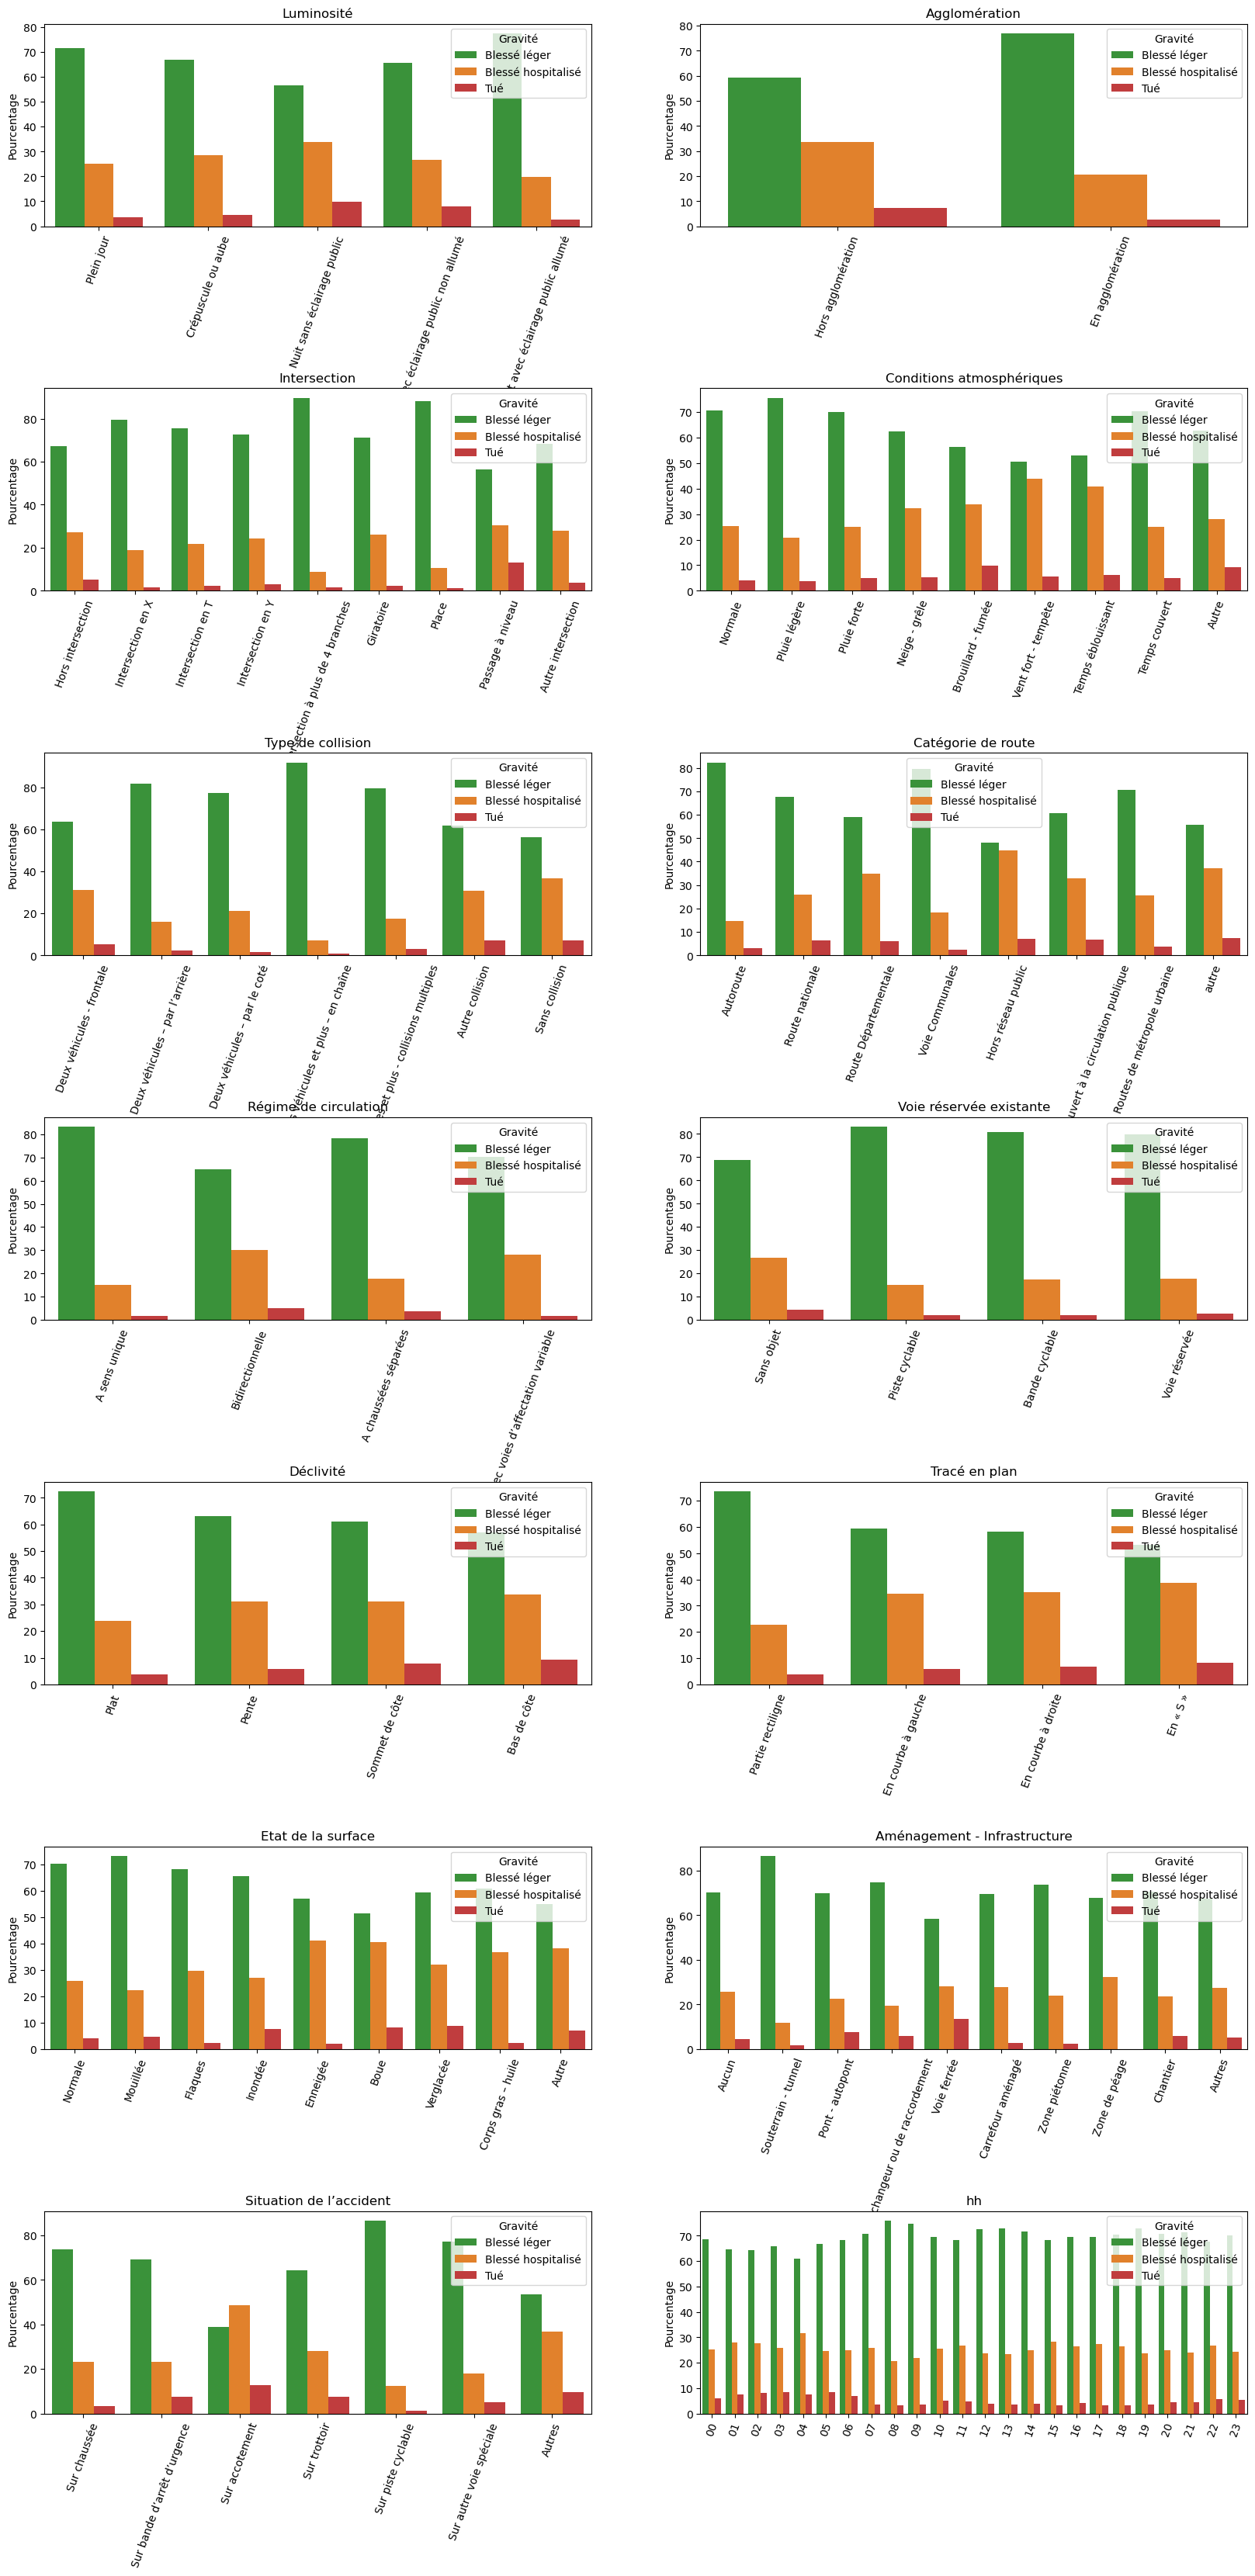

In [44]:
plot_categorical(carac, [ 'lum', 'agg', 'int', 'atm', 'col','catr','circ','vosp','prof','plan','surf','infra','situ','hh'],'grav')


In [45]:
chi2(carac, [ 'lum', 'agg', 'int', 'atm', 'col','catr','circ','vosp','prof','plan','surf','infra','situ','hh', 'dep'],'grav')


Luminosité  :  2.7839789857231304e-212
Agglomération  :  0.0
Intersection  :  7.87859478632891e-163
Conditions atmosphériques  :  5.241004519511255e-66
Type de collision  :  0.0
Catégorie de route  :  0.0
Régime de circulation  :  0.0
Voie réservée existante  :  4.226515089112855e-98
Déclivité  :  1.9268165818702647e-95
Tracé en plan  :  5.886542914234827e-211
Etat de la surface  :  2.4615536584525274e-19
Aménagement - Infrastructure  :  9.316745571186245e-33
Situation de l’accident  :  0.0
hh  :  6.950128940121344e-54
dep  :  0.0


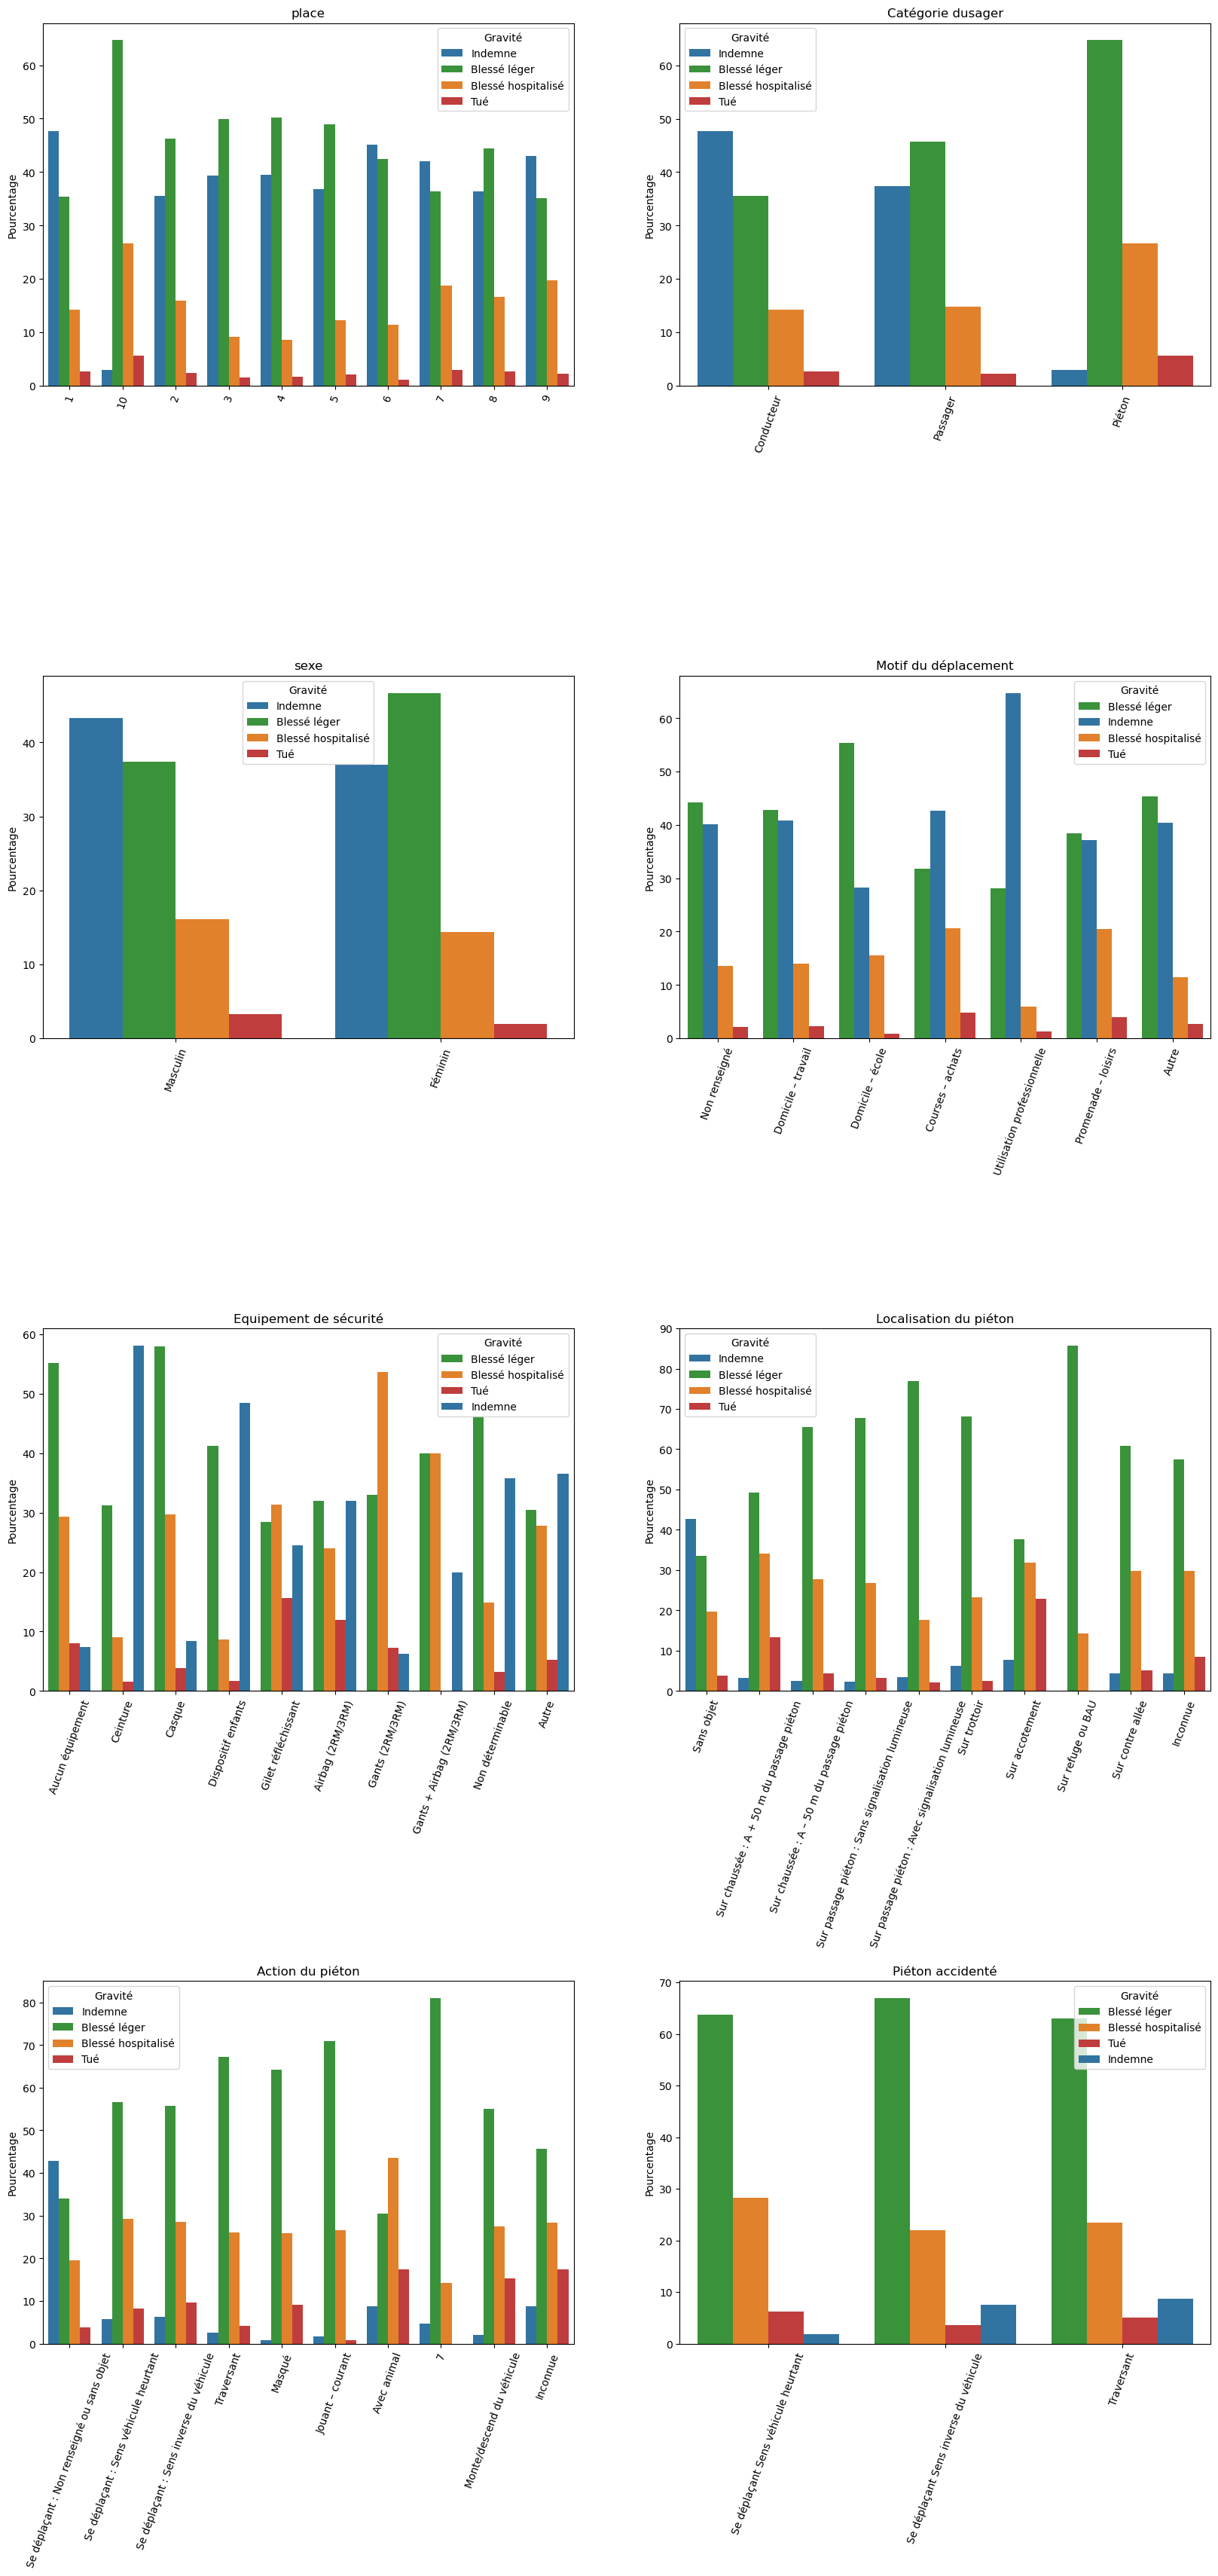

In [46]:
plot_categorical(usagers[usagers['grav']!='-1'], ['place','catu','sexe','trajet', 'secu1', 'locp','actp','etatp'],'grav')

In [47]:
chi2(usagers[usagers['grav']!='-1'], ['place','catu','sexe','trajet', 'secu1', 'locp','actp','etatp'],'grav')

KeyError: 'place'

In [ ]:
plot_categorical(vehicules, 

,Num_Acc,senc,catv,obs,obsm,choc,manv,motor,occutc
id_vehicule,,,,,,,,,
813 952,202200000001,1,2,0,2,1,9,1,NaN
813 953,202200000001,1,7,0,2,2,1,1,NaN
813 950,202200000002,2,7,0,2,8,15,1,NaN
813 951,202200000002,2,10,0,2,1,1,1,NaN
813 948,202200000003,2,7,0,2,1,2,1,NaN
...,...,...,...,...,...,...,...,...,...
715 633,202200055300,2,7,2,0,1,1,1,NaN
715 631,202200055301,2,7,0,0,8,19,1,NaN
715 632,202200055301,2,7,0,2,1,1,1,NaN
